# Part II - Ford GoBike System Data Exploration
## by Blessing Egharevba




## Investigation Overview

> In this investigation, I want to look at the influence of different features like age, gender, time of ride on the least time taken in completing rides.



## Dataset Overview

> The data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.
There are 183,411 individual rides in the dataset, with 16 features ('duration_sec', 'start_time', 'end_time', 'start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type', 'member_birth_year', 'member_gender', 'bike_share_for_all_trip'). Some of the variables ate numeric, some string. It can also be noted that some of the variables were formatted wrongly (eg, start_time and end_time formated as string instead of datetime). Data Wrangling was performed to improve the dataset usability.



In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
ford_df = pd.read_csv("201902-fordgobike-tripdata.csv")

In [3]:
# fill missing values in member_gender with "other"
ford_df["member_gender"] = ford_df["member_gender"].fillna("Other")

# fill missing values in member_birth_year with the year median
ford_df["member_birth_year"] = ford_df["member_birth_year"].fillna(ford_df["member_birth_year"].median())

# drop rows with missing values in start_station_id and end_station_id
ford_df.dropna(subset=['start_station_id'], inplace = True)

In [4]:
# convert start_time and end_time to datetime
ford_df['start_time'] = pd.to_datetime(ford_df['start_time'])
ford_df['end_time'] = pd.to_datetime(ford_df['end_time'])

# convert start_station_id and end_station_id to string
ford_df['start_station_id'] = ford_df['start_station_id'].astype("Int32").astype("str")
ford_df['end_station_id'] = ford_df['end_station_id'].astype("Int32").astype("str")

# convert bike_id to string
ford_df['bike_id'] = ford_df['bike_id'].astype("str")

# convert user_type, member_gender, bike_share_for_all_trip to category
ford_df['user_type'] = ford_df['user_type'].astype("category")
ford_df['member_gender'] = ford_df['member_gender'].astype("category")
ford_df['bike_share_for_all_trip'] = ford_df['bike_share_for_all_trip'].astype("category")

# convert member_bith_year from float to int
ford_df.member_birth_year = ford_df.member_birth_year.astype('Int32')

In [5]:
# extract year, month, day, hour and weekday from start_time and end_time to get more insights

ford_df["start_month"] = ford_df.start_time.dt.strftime("%B")
ford_df["start_day"] = ford_df.start_time.dt.day
ford_df["start_hour"] = ford_df.start_time.dt.hour
ford_df["start_weekday"] = ford_df.start_time.dt.strftime("%A")


ford_df["end_month"] = ford_df.end_time.dt.strftime("%B")
ford_df["end_day"] = ford_df.end_time.dt.day
ford_df["end_hour"] = ford_df.end_time.dt.hour

In [6]:
# using cut to get the time of the day from the start_hour

bins = [0,5,12,16,20,24]
labels = ['Early Morning','Morning','Afternoon','Evening','Night']
ford_df['period'] = pd.cut(ford_df['start_hour'], bins=bins, labels=labels, include_lowest=True)

In [7]:
# convert startweekday and period into ordered categorical types
ordinal_var_dict = {'start_weekday': ['Monday','Tuesday','Wednesday','Thursday', "Friday", "Saturday", 'Sunday'],
                    'period': ['Early Morning','Morning','Afternoon','Evening','Night'],}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    ford_df[var] = ford_df[var].astype(ordered_var)

In [8]:
# since the ride was taken in 2019, the expected age of the riders will be calculated as at 2019

ford_df["age"] = ford_df["member_birth_year"].apply(lambda x : 2019-x).astype("int")

In [9]:
# create a new column by converting seconds to mins and then to ints
ford_df["duration_min"] = ford_df["duration_sec"].apply(lambda x : x/60)
ford_df["duration_min"] = np.ceil(ford_df["duration_min"]).astype("int")

## Distribution of Duration in seconds

> Distribution of the duration took a highly right-skewed distributionbetween zero and 1000secs. Plotted on a logarithmic scale, the distribution of duration in secs takes on a normal distribution shape.

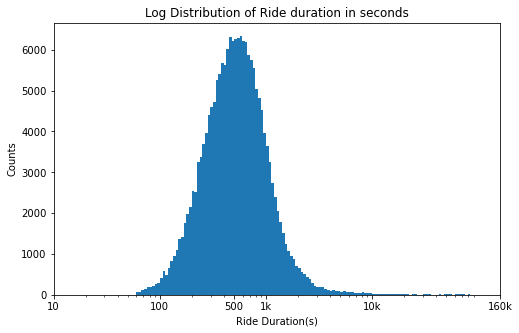

In [10]:
plt.figure(figsize=[8, 5])
log_binsize = 0.025
bins = 10**np.arange(1.2, np.log10(ford_df["duration_sec"].max())+log_binsize, log_binsize)

plt.hist(data = ford_df, x = "duration_sec", bins = bins)
plt.xscale("log")

x_ticks = [10, 100,500,1000, 10000, 160e3]
plt.xticks(x_ticks, [10, 100, 500,"1k", "10k", "160k"])

plt.title("Log Distribution of Ride duration in seconds")
plt.xlabel("Ride Duration(s)")
plt.ylabel("Counts");

## Distribution of Rider's Age

> Distribution of the rider's age took a  right-skewed distribution falling between 20 and 60years. Plotted on a logarithmic scale, the distribution of rider's age takes on a multimodal shape.

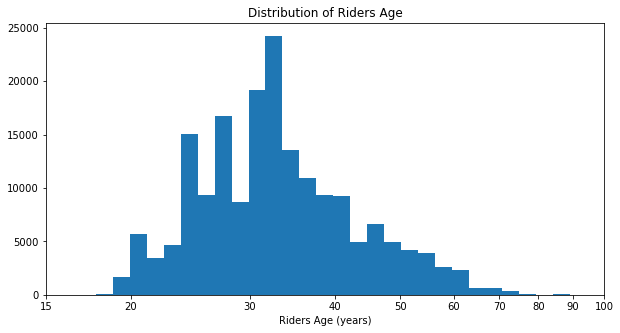

In [11]:
plt.figure(figsize = [10,5])

log_binsize = 0.025
bins = 10**np.arange(1.2, np.log10(ford_df["age"].max())+log_binsize, log_binsize)

plt.hist(data = ford_df, x = "age", bins = bins)
plt.xscale("log")

x_ticks = [15, 20, 30, 40,50, 60, 70, 80, 90, 100, 150]
plt.xticks(x_ticks, x_ticks)
plt.xlim(15, 100)

plt.title("Distribution of Riders Age")
plt.xlabel("Riders Age (years)");

## Average duration covered by weekdays and time of the Day

> Having the lowest rides, the highest avg duration (secs) occured on __Weekends__. Tuesday had the lowest avg duration covered. <br>
> The longest rides were covered during the **Afternoon**, with the lowest ride covered **morning** which had the highest number of rides taken

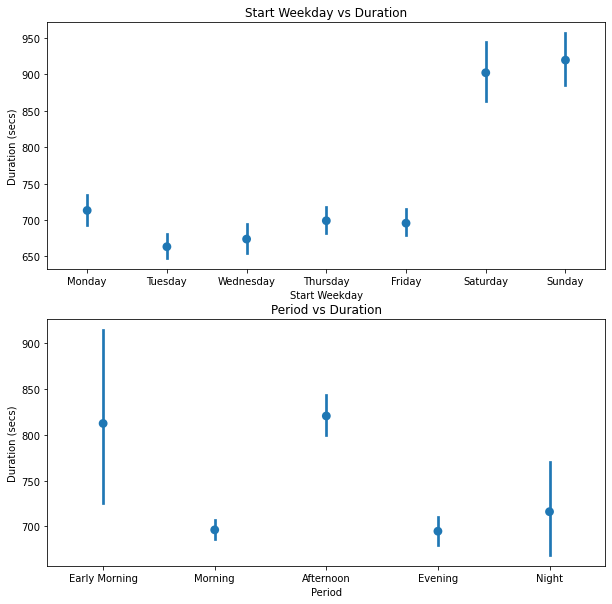

In [12]:
fig, ax = plt.subplots(nrows=2, figsize = [10,10])

sb.pointplot(data = ford_df, x = "start_weekday", y = "duration_sec", linestyles = "", ax = ax[0] )
ax[0].set_xlabel("Start Weekday")
ax[0].set_ylabel("Duration (secs)")
ax[0].set_title("Start Weekday vs Duration")

sb.pointplot(data = ford_df, x = "period", y = "duration_sec",linestyles = "", ax = ax[1])
ax[1].set_xlabel("Period")
ax[1].set_ylabel("Duration (secs)")
ax[1].set_title("Period vs Duration");

## Correlation between Age and Duration spent by Gender
> There is no correlation between age and duration spend, plotting by Gender 

In [13]:
ford_plot_data = ford_df.loc[ford_df["member_gender"].isin(["Female", "Male"])]
ford_plot_data = ford_plot_data.sample(3000)

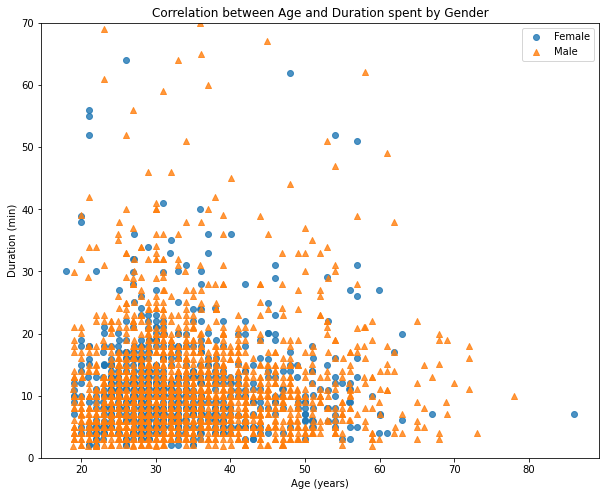

In [14]:
gender_marker = [["Female", "o"], 
                 ["Male", "^"]]

plt.figure(figsize = [10,8])

for gender, marker in gender_marker:
    plot_df = ford_plot_data.loc[ford_plot_data["member_gender"] == gender]
    sb.regplot(data = plot_df, x = "age", y ="duration_min", 
              fit_reg = False, x_jitter = 0.04,y_jitter = 0.04, marker = marker,)
plt.legend(["Female", "Male"])
plt.ylim(0,70)
plt.xlabel("Age (years)")
plt.ylabel("Duration (min)")
plt.title("Correlation between Age and Duration spent by Gender");

## Average duration taken by each gender at different time of the day
> Females riders had the least average ride at Night and the longest ride early morning, taking above 1000secs. <br>
Male riders have an almost equal number of average duration ride throughout the time period, but having morning as the least duration. Though from the bivariant plot above, male had more rides in the morning compared to afternnons<br>
Other gender had their least duration in the evening and the highest early morning.<br>

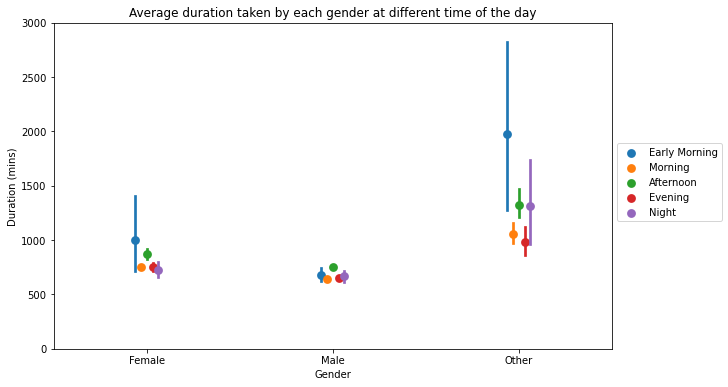

In [15]:
plt.figure(figsize = [10,6])
sb.pointplot(data = ford_df, x = "member_gender", y = "duration_sec", hue = "period",
            linestyles = "", dodge = True)
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.51))
plt.ylim(0, 3000)
plt.xlabel("Gender")
plt.ylabel("Duration (mins)")
plt.title("Average duration taken by each gender at different time of the day");

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [17]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt